In [1]:
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from numpy.linalg import norm
import numpy as np
import random
import sys

In [2]:
# function from https://github.com/simongravelle/python-for-lammps
def randomlocation(Lx,Ly,Lz):
    '''Choose a random location within a given box'''
    txlo, txhi = -Lx/2, Lx/2
    tylo, tyhi = -Ly/2, Ly/2
    tzlo, tzhi = -Lz/2, Lz/2    
    x = random.randint(1,1000)/1000*(txhi-txlo)+txlo
    y = random.randint(1,1000)/1000*(tyhi-tylo)+tylo
    z = random.randint(1,1000)/1000*(tzhi-tzlo)+tzlo
    return x, y, z
def randomorientation(XYZ):
    '''3D aleatory rotation of molecule/particule coordinate'''
    rotation_degrees = random.randint(0,9000)/100
    rotation_radians = np.radians(rotation_degrees)
    rotation_axis = np.array([random.randint(0,100)/100, random.randint(0,100)/100, random.randint(0,100)/100])
    rotation_axis /= np.linalg.norm(rotation_axis)
    rotation_vector = rotation_radians * rotation_axis
    rotation = R.from_rotvec(rotation_vector)
    mol_rotated = rotation.apply(XYZ)    
    return mol_rotated.T

In [3]:
Na = 6.022e23 #constants.Avogadro
Mh2o = 0.018053 # kg/mol - water

### system parameters

In [4]:
dw = 3.2 # initial inter-molecule distances (A)
Ntot = 2000 # desired number of species (ion + water)
c = 5
nion = c*Ntot*Mh2o/(2*(1+Mh2o*c)) # desired number for each ion
nwater = Ntot - 2*nion
co = 3 # cut-off for incerting new molecule

### types of atoms, bonds, and angles

In [5]:
Tatom = 4 # Na, Cl, O, H
Tbond = 1 # O-H
Tangle = 1 # H-O-H

### import water molecule information

In [6]:
Ph2o = np.loadtxt('../../../shared/H2O_TIP4P2005/Position.dat')
Bh2o = np.loadtxt('../../../shared/H2O_TIP4P2005/Bond.dat')
Ah2o = np.loadtxt('../../../shared/H2O_TIP4P2005/Angle.dat')

### add water and ions

If the box is too small, increase it until all species fit

In [7]:
cptH2O = 0
cptNa = 0
cptCl = 0
attemps = 0
while cptH2O+cptNa+cptCl < (Ntot-3):
    
    Lx, Ly, Lz = 30+2*attemps*dw, 30+2*attemps*dw, 30+2*attemps*dw # initial box size (A)
    box = np.array([Lx, Ly, Lz])
    txlo, txhi = -Lx/2, Lx/2
    tylo, tyhi = -Ly/2, Ly/2
    tzlo, tzhi = -Lz/2, Lz/2
    print('Box size Lx = '+str(np.round(Lx,2))+' A')
        
    cptatom = 0
    cptbond = 0
    cptangle = 0
    cptmol = 0
    cptH2O = 0
    cptCl = 0
    cptNa = 0
    cptCl = 0
    
    # allocate memory
    atoms = np.zeros((100000,7))
    bonds = np.zeros((100000,4))
    angles = np.zeros((100000,5))
    # add Cl ions
    try_ins = 0
    while (cptCl < nion-1) & (try_ins<1e4):
        x,y,z = randomlocation(Lx,Ly,Lz)
        if cptatom == 0:
            atoms[cptatom] = cptatom+1, cptmol+1, 4, -1, x, y, z
            cptatom += 1
            cptmol += 1
            cptCl += 1
        else : 
            # look for overlap
            dxdydz = np.remainder(atoms[:cptatom].T[4:7].T - np.array([x,y,z]) + box/2., box) - box/2.
            minr = np.min(norm(dxdydz,axis=1))
            if minr > co:
                atoms[cptatom] = cptatom+1, cptmol+1, 4, -1, x, y, z
                cptatom += 1
                cptmol += 1
                cptCl += 1
            else:
                try_ins += 1
    # add Na ions
    tryins = 0
    while (cptNa < nion-1) & (try_ins<1e4):
        x,y,z = randomlocation(Lx,Ly,Lz)
        # look for overlap
        dxdydz = np.remainder(atoms[:cptatom].T[4:7].T - np.array([x,y,z]) + box/2., box) - box/2.
        minr = np.min(norm(dxdydz,axis=1))
        if minr > co:
            atoms[cptatom] = cptatom+1, cptmol+1, 3, 1, x, y, z
            cptatom += 1
            cptmol += 1
            cptNa += 1
        else:
            try_ins += 1
    # add water molecules
    for cut in [0.2,0.4,0.6,0.8,1]:
        for z in np.arange(tzlo+dw/2,tzhi-dw/2,dw):
            for x in np.arange(txlo+dw/2,txhi-dw/2,dw):
                for y in np.arange(tylo+dw/2,tyhi-dw/2,dw):
                    if cptH2O < nwater-1: 
                        rnd = random.random()
                        if rnd <= cut: # allow a better filling of the box
                            Ph2o.T[4:7] = randomorientation(Ph2o.T[4:7].T)
                            # look for overlap
                            dxdydz = np.remainder(atoms[:cptatom].T[4:7].T - np.array([x,y,z]) + box/2., box) - box/2.
                            minr = np.min(norm(dxdydz,axis=1))
                            if minr > co:
                                for m in Bh2o:
                                    bonds[cptbond] = cptbond+1, m[1], m[2]+cptatom, m[3]+cptatom
                                    cptbond += 1

                                m = Ah2o
                                angles[cptangle] = cptangle+1, m[1], m[2]+cptatom, m[3]+cptatom, m[4]+cptatom
                                cptangle += 1 

                                for m in Ph2o:
                                    atoms[cptatom] = cptatom+1, cptmol, m[2], m[3], m[4]+x, m[5]+y, m[6]+z
                                    cptatom += 1 
                                cptmol += 1
                                cptH2O += 1
    attemps += 1
    print(str(cptNa)+' / '+str(np.int32(nion))+' na atom')
    print(str(cptCl)+' / '+str(np.int32(nion))+' cl atom')
    print(str(cptH2O)+' / '+str(np.int32(nwater))+' water molecules')
    print(' ')

Box size Lx = 30.0 A
82 / 82 na atom
82 / 82 cl atom
179 / 1834 water molecules
 
Box size Lx = 36.4 A
82 / 82 na atom
82 / 82 cl atom
421 / 1834 water molecules
 
Box size Lx = 42.8 A
82 / 82 na atom
82 / 82 cl atom
776 / 1834 water molecules
 
Box size Lx = 49.2 A
82 / 82 na atom
82 / 82 cl atom
1246 / 1834 water molecules
 
Box size Lx = 55.6 A
82 / 82 na atom
82 / 82 cl atom
1834 / 1834 water molecules
 


### delete unecessary lines

In [8]:
atoms = atoms[0:cptatom]       
bonds = bonds[0:cptbond]    
angles = angles[0:cptangle]

### show system

In [9]:
Oxy = atoms[atoms.T[2] == 1]
Hyd = atoms[atoms.T[2] == 2]
Na = atoms[atoms.T[2] == 3]
Cl = atoms[atoms.T[2] == 4]

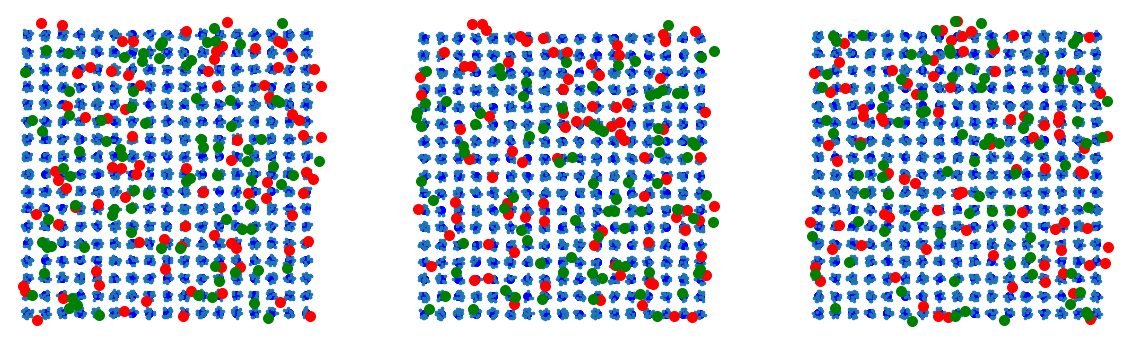

In [10]:
fig = plt.figure(figsize=(20,20))
# panel 1
ax1 = plt.subplot(1, 3, 1)
ax1.plot(Oxy.T[4], Oxy.T[5],'b.',markersize=15)
ax1.plot(Hyd.T[4], Hyd.T[5],'.',markersize=5)
ax1.plot(Na.T[4], Na.T[5],'r.',markersize=20)
ax1.plot(Cl.T[4], Cl.T[5],'g.',markersize=20)
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_aspect((x1-x0)/(y1-y0))
ax1.axis('off')
# panel 2
ax2 = plt.subplot(1, 3, 2)
ax2.plot(Oxy.T[6], Oxy.T[4],'b.',markersize=15)
ax2.plot(Hyd.T[6], Hyd.T[4],'.',markersize=5)
ax2.plot(Na.T[6], Na.T[4],'r.',markersize=20)
ax2.plot(Cl.T[6], Cl.T[4],'g.',markersize=20)
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax2.set_aspect((x1-x0)/(y1-y0))
ax2.axis('off')
# panel 3
ax3 = plt.subplot(1, 3, 3)
ax3.plot(Oxy.T[5], Oxy.T[6],'b.',markersize=15)
ax3.plot(Hyd.T[5], Hyd.T[6],'.',markersize=5)
ax3.plot(Na.T[5], Na.T[6],'r.',markersize=20)
ax3.plot(Cl.T[5], Cl.T[6],'g.',markersize=20)
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax3.set_aspect((x1-x0)/(y1-y0))
ax3.axis('off')
plt.show()

### write data.lammps

In [11]:
f = open("data.lammps", "w")
f.write('# LAMMPS data file \n\n')
f.write(str(cptatom)+' atoms\n')
f.write(str(cptbond)+' bonds\n')
f.write(str(cptangle)+' angles\n')
f.write('\n')
f.write(str(Tatom)+' atom types\n')
f.write(str(Tbond)+' bond types\n')
f.write(str(Tangle)+' angle types\n')
f.write('\n')
f.write(str(txlo)+' '+str(txhi)+' xlo xhi\n')
f.write(str(tylo)+' '+str(tyhi)+' ylo yhi\n')
f.write(str(tzlo)+' '+str(tzhi)+' zlo zhi\n')
f.write('\n')
f.write('Atoms\n')
f.write('\n')
for nlin in range(len(atoms)):
    newline = atoms[nlin]
    for col in range(len(newline)):
        if col < 3:
            f.write(str(int(newline[col]))+' ')
        else :
            f.write(str(newline[col])+' ')
    f.write('\n')
f.write('\n')
f.write('Bonds\n')
f.write('\n')
for nlin in range(len(bonds)):
    newline = bonds[nlin]
    for col in range(len(newline)):
        f.write(str(int(newline[col]))+' ')
    f.write('\n')
f.write('\n')
f.write('Angles\n')
f.write('\n')
for nlin in range(len(angles)):
    newline = angles[nlin]
    for col in range(len(newline)):
        f.write(str(int(newline[col]))+' ')
    f.write('\n')
f.close()